In [1]:
import networkx as nx
from keras.models import model_from_json
import pickle
import os
import json
from copy import deepcopy
import pandas
import math
import random
from CGRtools.files import RDFread, RDFwrite, SDFread
from CGRtools.containers import ReactionContainer
from CGRtools.preparer import CGRpreparer
from CGRtools.reactor import CGRreactor
from CIMtools.preprocessing import StandardizeChemAxon
from networkx import DiGraph
from tqdm import tqdm
from tqdm import tnrange
from CGRtools.files import SDFwrite
import matplotlib.pyplot as plt

/home/aigul/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_keras_json_file = "/home/aigul/Retro/keras_models/80_200_325_1*2000/model_36_epochs.json"
path_to_keras_h5_file = "/home/aigul/Retro/keras_models/80_200_325_1*2000/model_36_epochs.h5"
path_to_fragmentor = "/home/aigul/Retro/finalize_descriptors.pickle"
path_to_file_with_mol = "/home/aigul/Desktop/paths/target23.sdf"

json_file = open(path_to_keras_json_file, 'r')  # load json and create model
loaded_model_json = json_file.read()
json_file.close()
keras_model = model_from_json(loaded_model_json)
keras_model.load_weights(path_to_keras_h5_file)  # load weights into new model
os.environ["PATH"] += ":/opt/fragmentor"
with open(path_to_fragmentor, "rb") as f:
    fr = pickle.load(f)
target = SDFread(path_to_file_with_mol).read()
with SDFread("/home/aigul/Retro/signature/rules.sdf", "r") as f2:
    CGR_env_hyb = f2.read()
with open("/home/aigul/Retro/OldNewNumsOfRules.json") as json_file:
    old_new_nums_of_rules = json.load(json_file)
reverse_dict = {}
for i, j in old_new_nums_of_rules.items():
    reverse_dict[j] = i
with open("/home/aigul/Desktop/paths/reagents23.pickle", "rb") as f7:
    reagents_in_store = pickle.load(f7)
with open("/home/aigul/Retro/stand/stand1.xml", "r") as stand_file:
    std = stand_file.read()
standardizer = StandardizeChemAxon(std)

reagents_in_store = set(reagents_in_store)

target = standardizer.transform(SDFread(path_to_file_with_mol).read()).as_matrix()[0]

/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
# create array descriptor from molecule
def prep_mol_for_nn(mol_container):
    descriptor = fr.transform([mol_container])
    descriptor_array = descriptor.values
    return descriptor_array


def prediction(descriptor_array):
    prediction = keras_model.predict(descriptor_array)
    return prediction


def return_patterns_rollout(prediction_for_mol):
    u = pandas.DataFrame(prediction_for_mol).iloc[0, :2957].sort_values(ascending=False)[0]
    transform_num = pandas.DataFrame(prediction_for_mol).iloc[0, :2957].sort_values(ascending=False).keys()[0]
    pattern_nums_in_file = []
    pattern_nums_in_file.append(reverse_dict[transform_num])
    return dict(zip(pattern_nums_in_file, [u]))


def return_patterns_expansion(prediction_for_mol):
    number_selected_patterns = 9
    u = pandas.DataFrame(prediction_for_mol).iloc[0, :2957].sort_values(ascending=False)
    count = 0
    sum_u = 0
    transform_num = []
    transform_prob = []
    for j, i in enumerate(list(u.values)):
        count += 1
        sum_u += i
        transform_prob.append(i)
        transform_num.append(list(u.keys())[j])
        if len(transform_num) > number_selected_patterns:
            break
        elif sum_u >= 0.9:
            break
    pattern_nums_in_file = []
    for new_pattern_num in transform_num:
        pattern_nums_in_file.append(reverse_dict[new_pattern_num])
    return dict(zip(pattern_nums_in_file, transform_prob))

In [4]:
def create_mol_from_pattern(pattern_nums_in_file, molecule):
    cgr_patterns = []
    cgr_prob = []
    prob_end = []
    destroy_all = []
    created_reactions = []
    for cgr in CGR_env_hyb:
        if cgr.meta["id"] in pattern_nums_in_file.keys():
            cgr_patterns.append(cgr)
            cgr_prob.append(pattern_nums_in_file[cgr.meta["id"]])

    reagents_reactions_probs = []
    for cgr_nums in range(len(cgr_patterns)):
        cgr_pattern = cgr_patterns[cgr_nums]
        cgr_to_reaction = CGRpreparer.decompose(cgr_pattern)
        prod_from_cgr = cgr_to_reaction.products
        reag_from_cgr = cgr_to_reaction.reagents
        if len(reag_from_cgr) < 3:
            react = CGRreactor()
            with RDFwrite("/home/aigul/Retro/templates/test" + str(len(lemon_tree.nodes)) + ".template") as f:
                f.write(ReactionContainer(reagents=[prod_from_cgr[0]], products=reag_from_cgr))
            with RDFread("/home/aigul/Retro/templates/test" + str(len(lemon_tree.nodes)) + ".template",
                         is_template=True) as f:
                template = react.prepare_templates(f.read())
            searcher = react.get_template_searcher(templates=template)
            for i in searcher(molecule):
                destroy = react.patcher(structure=molecule, patch=i.patch)
            try:
                destroy_all.append(CGRpreparer.split(destroy))
                prob_end.append(cgr_prob[cgr_nums])
                for j in range(len(destroy_all)):
                    created_reactions.append(ReactionContainer(reagents=destroy_all[j], products=[molecule]))
                    created_reactions = standardizer.transform(created_reactions).as_matrix()
                    reagents_reactions_probs.append([[created_reactions[0].reagents], created_reactions, prob_end])
            except:
                continue
    if len(reagents_reactions_probs) == 0:
        return 0
    else:
        return reagents_reactions_probs

In [5]:
class LemonTree(DiGraph):
    def __init__(self, target):
        super().__init__()
        self.add_node(1, reagents=[target], depth=0, solved=False, reward=0,
                      number_of_visits=0, terminal=False, expanded=False)

    def add_node_(self, parent_node_number, list_of_reagents, probability):
        unique_number = len(self.nodes) + 1
        children_depth = int(self.nodes[parent_node_number]['depth']) + 1
        visiting = 0
        solved_ = False
        self.add_node(unique_number)
        dict_with_atrrs = {"reagents": list_of_reagents, "depth": children_depth,
                           "solved": solved_, "reward": 0, "number_of_visits": visiting,
                           "terminal": False, "Q": 0, "probability": probability, "a": 0,
                           "expanded": False}
        self.change_atrrs_of_node(unique_number, dict_with_atrrs)
        return unique_number

    def change_atrrs_of_node(self, node_number, dict_with_attrs):
        nx.set_node_attributes(self, {node_number: dict_with_attrs})

    def change_atrrs_of_edge(self, parent_node_number, node_number, reaction):
        edge_attrs = {(parent_node_number, node_number): {'reaction': reaction}}
        nx.set_edge_attributes(self, edge_attrs)

    def return_reaction(self, parent_node_number, new_node_number):
        return nx.get_edge_attributes(lemon_tree, "reaction")[parent_node_number, new_node_number]

    def node_depth(self, node_number):
        node_depth_ = self.nodes[node_number]['depth']
        return node_depth_

    @property
    def number_of_visits(self):
        return self.nodes(data="number_of_visits")

    @property
    def node_solved(self):
        return self.nodes(data="solved")

    def go_to_parent(self, node_number):
        try:
            parent = self._pred[node_number]
            return next(iter(parent))
        except:
            return node_number

    def add_edge_(self, parent_node_number, node_number, reaction):
        self.add_edge(parent_node_number, node_number)
        self.change_atrrs_of_edge(parent_node_number=parent_node_number, node_number=node_number, reaction=reaction)

    def go_to_node(self, node_number):
        return self.nodes[node_number]

    def go_to_child(self, parent_node_number):
        y = self.successors(parent_node_number)
        list_of_children = []
        for i in range(len(self.nodes) + 1):
            try:
                list_of_children.append(next(y))
            except:
                break
        return list_of_children

    def go_to_best_or_random_child(self, expanded_node_number):
        E = 0.2
        random_number = random.uniform(0, 1)
        y = self.successors(expanded_node_number)
        list_of_children = []
        for i in range(len(self.nodes) + 1):
            try:
                list_of_children.append(next(y))
            except:
                break
        if random_number < E:
            if len(list_of_children) == 0:
                return None
            else:
                return list_of_children[random.randint(0, len(list_of_children) - 1)]
        if random_number > E:
            best_num = 0
            if len(list_of_children) != 1:
                for num in range(len(list_of_children)):
                    if num + 1 < len(list_of_children):
                        if self.nodes[list_of_children[num]]['a'] < self.nodes[list_of_children[num + 1]]['a']:
                            best_num = num + 1
            else:
                best_num = 0

            if len(list_of_children) == 0:
                return None
            else:
                return list_of_children[best_num]

    def go_to_random_child(self, node_number):
        list_of_children = self.go_to_child(node_number)
        if len(list_of_children) == 0:
            return None
        else:
            return list_of_children[random.randint(0, len(list_of_children) - 1)]

    def is_terminal(self, parent_node_number):
        y = self.successors(parent_node_number)
        try:
            next(y)
        except:
            return True


lemon_tree = LemonTree(target)

In [6]:
def return_solutions(new_node_number):
    global synthetic_path
    parent_node_number = lemon_tree.go_to_parent(new_node_number)
    if new_node_number != parent_node_number:
        synthetic_path.append(
            lemon_tree.return_reaction(parent_node_number=parent_node_number, new_node_number=new_node_number))
        return_solutions(parent_node_number)
    if new_node_number == parent_node_number:
        with RDFwrite("/home/aigul/Retro/paths/prediction.rdf") as f:
            for solution in synthetic_path:
                f.write(solution)
        synthetic_path = []

In [7]:
def update(new_node_number, reward):
    node_attrs_2 = {"number_of_visits": lemon_tree.nodes[new_node_number]["number_of_visits"] + 1,
                    "reward": lemon_tree.nodes[new_node_number]["reward"] + (reward)}
    lemon_tree.change_atrrs_of_node(node_number=new_node_number, dict_with_attrs=node_attrs_2)
    Q = (1 / (lemon_tree.nodes[new_node_number]["number_of_visits"])) * (lemon_tree.nodes[new_node_number]["reward"])
    P = lemon_tree.nodes[new_node_number]["probability"]  # prob from NN
    parent_node = lemon_tree.go_to_parent(new_node_number)
    N = lemon_tree.nodes[new_node_number]["number_of_visits"]
    N_pred = lemon_tree.nodes[parent_node]["number_of_visits"]
    a = (Q) + P * (math.sqrt(N_pred) / (1 + N))
    node_attrs_3 = {"Q": Q, "a": a}
    lemon_tree.change_atrrs_of_node(node_number=new_node_number, dict_with_attrs=node_attrs_3)
    if parent_node != 1:
        update(parent_node, reward)

In [8]:
def expansion(node_number):
    global solution_found_counter
    max_depth = 10
    current_node = lemon_tree.go_to_node(node_number)
    list_of_reagents = current_node["reagents"]
    if list_of_reagents == []:
        lemon_tree.change_atrrs_of_node(node_number=node_number, dict_with_attrs={"expanded": True})
        return
    mol_container = list_of_reagents[0]
    lemon_tree.change_atrrs_of_node(node_number=node_number, dict_with_attrs={"expanded": True})
    new_patterns = return_patterns_expansion(prediction(prep_mol_for_nn(mol_container)))
    if len(new_patterns) == 0:
        lemon_tree.nodes[node_number]["terminal"] = True
        update(node_number, -1)
    elif len(new_patterns) != 0:
        if lemon_tree.nodes[node_number]["terminal"] != True:
            new_mols_from_pred = create_mol_from_pattern(new_patterns, mol_container)
            if new_mols_from_pred == 0:
                lemon_tree.change_atrrs_of_node(node_number=node_number, dict_with_attrs={"terminal": True})
                update(node_number, -1)
            else:
                for new_mol in new_mols_from_pred:
                    for j2 in range(len(new_mol[0])):
                        copy_of_list_of_reagents = deepcopy(list_of_reagents[1:])
                        # check compounds in DB and if yes exclude it from node molecule list
                        for j3 in new_mol[0][j2]:
                            if j3.get_signature_hash() not in reagents_in_store:
                                copy_of_list_of_reagents.append(j3)

                        # check if node exist if Rollout = False? if not:
                        # in rollout == False we add new nodes, 1) if children of nodes absent
                        # and 2) if list of hashes != list of new list of hashes; if we have one prediction and this prediction in node we continue

                        if lemon_tree.go_to_child(node_number) == []:
                            new_node_number = lemon_tree.add_node_(list_of_reagents=copy_of_list_of_reagents,
                                                                   parent_node_number=node_number,
                                                                   probability=new_mol[2][j2])

                            lemon_tree.add_edge_(parent_node_number=node_number, node_number=new_node_number,
                                                 reaction=new_mol[1][j2])
                        else:
                            repeated = False
                            for child_num in range(len(lemon_tree.go_to_child(node_number))):
                                if lemon_tree.nodes[lemon_tree.go_to_child(node_number)[child_num]][
                                    "reagents"] == copy_of_list_of_reagents:
                                    repeated = True
                            if repeated == False:
                                new_node_number = lemon_tree.add_node_(list_of_reagents=copy_of_list_of_reagents,
                                                                       parent_node_number=node_number,
                                                                       probability=new_mol[2][j2])
                                lemon_tree.add_edge_(parent_node_number=node_number, node_number=new_node_number,
                                                     reaction=new_mol[1][j2])
                            else:
                                lemon_tree.change_atrrs_of_node(node_number=node_number, dict_with_attrs={"expanded": True})
                                return lemon_tree.go_to_child(node_number)
                        if lemon_tree.node_depth(new_node_number) > max_depth and lemon_tree.node_solved(
                                new_node_number) is False:
                            update(new_node_number, -1)
                        elif len(lemon_tree.nodes[new_node_number]["reagents"]) == 0:
                            lemon_tree.change_atrrs_of_node(node_number=new_node_number,
                                                            dict_with_attrs={"solved": True, "expanded": True,
                                                                             "terminal": True})
                            solution_found_counter += 1
                            winner_nodes.append(new_node_number)
                            update(new_node_number, 1)
            return lemon_tree.go_to_child(parent_node_number=node_number)

In [9]:
def rollout(node_number):
    global solution_found_counter
    max_depth = 10
    current_node = lemon_tree.go_to_node(node_number)
    list_of_reagents = current_node["reagents"]
    if list_of_reagents == []:
        return
    mol_container = list_of_reagents[0]
    new_patterns = return_patterns_rollout(prediction(prep_mol_for_nn(mol_container)))
    if len(new_patterns) == 0:
        lemon_tree.nodes[node_number]["terminal"] = True
        update(node_number, -1)
    if lemon_tree.nodes[node_number]["terminal"] != True:
        new_mols_from_pred = create_mol_from_pattern(new_patterns, mol_container)
        

        if new_mols_from_pred == 0:
            lemon_tree.change_atrrs_of_node(node_number=node_number, dict_with_attrs={"terminal": True})
            update(node_number, -1)
        else:
            for new_mol in new_mols_from_pred:
                for j2 in range(len(new_mol[0])):
                    copy_of_list_of_reagents = deepcopy(list_of_reagents[1:])
                    # check compounds in DB and if yes exclude it from node molecule list
                    for j3 in new_mol[0][j2]:
                        if j3.get_signature_hash() not in reagents_in_store:
                            copy_of_list_of_reagents.append(j3)
                    # check if node exist if Rollout = False? if not:
                    # in rollout == False we add new nodes, 1) if children of nodes absent
                    # and 2) if list of hashes != list of new list of hashes; if we have one prediction and this prediction in node we continue
                    if lemon_tree.go_to_child(node_number) == []:
                        new_node_number = lemon_tree.add_node_(list_of_reagents=copy_of_list_of_reagents,
                                                               parent_node_number=node_number,
                                                               probability=new_mol[2][j2])

                        lemon_tree.add_edge_(parent_node_number=node_number, node_number=new_node_number,
                                             reaction=new_mol[1][j2])
                    else:
                        break
                    if lemon_tree.node_depth(new_node_number) > max_depth and lemon_tree.node_solved(
                            new_node_number) is False:
                        update(new_node_number, -1)
                    elif len(lemon_tree.nodes[new_node_number]["reagents"]) == 0:
                        lemon_tree.change_atrrs_of_node(node_number=new_node_number,
                                                        dict_with_attrs={"solved": True, "expanded": True,
                                                                         "terminal": True})
                        solution_found_counter += 1
                        winner_nodes.append(new_node_number)
                        update(new_node_number, 1)
                    else:
                        rollout(new_node_number)

In [10]:
def expanded_nodes_in_tree():
    for node in lemon_tree.nodes:
        if not lemon_tree.nodes[node]["expanded"] and lemon_tree.nodes[node]["terminal"]:
            return True


def search(s):
    if len(lemon_tree.nodes) == 1:
        return s
    while lemon_tree.go_to_best_or_random_child(s):
        s = lemon_tree.go_to_best_or_random_child(s)
        if not lemon_tree.nodes[s]["expanded"]:
            return s


def random_search(s):
    if expanded_nodes_in_tree():
        while lemon_tree.go_to_random_child(s):
            s = lemon_tree.go_to_random_child(s)
            if not lemon_tree.nodes[s]["expanded"]:
                return s


def MCTsearch(Max_Iteration, Max_Num_Solved):
    max_depth = 10
    for i in tnrange(Max_Iteration):
        if solution_found_counter < Max_Num_Solved:
            node_number = 1
            new_node_number = search(node_number) or random_search(node_number)
            if not new_node_number:
                continue
            if lemon_tree.node_depth(new_node_number) < max_depth:
                expanded_nodes_nums = expansion(new_node_number)
                if expanded_nodes_nums:
                    for expanded_node in expanded_nodes_nums:
                        rollout(expanded_node)
                else:
                    continue

In [11]:
synthetic_path = []
solution_found_counter = 0
winner_nodes = []

MCTsearch(Max_Iteration=100, Max_Num_Solved=2)
if solution_found_counter > 0:
    a = []
    for node in winner_nodes:
        a.append(lemon_tree.nodes[node]["a"])
    a_dict = dict(zip(a, winner_nodes))
    sorted_a = sorted(a_dict.keys())
    sorted_a.reverse()
    for i in sorted_a:
        for j in a_dict.keys():
            if i == j:
                return_solutions(a_dict[j])

/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/aigul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead

In [12]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    ''' For drawing LemonTree
    If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root)) 
    if parent != None:   #this should be removed for directed graphs.
        neighbors.remove(parent)  #if directed, then parent not in neighbors.
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

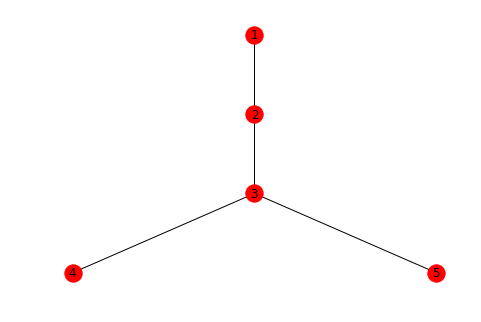

In [13]:
G_copy=nx.Graph()
G_copy.add_edges_from(list(lemon_tree.edges()))
pos = hierarchy_pos(G_copy,1)  
nx.draw(G_copy, pos=pos, with_labels=True)

In [ ]:
synthetic_path_manual = []
def manual_return_solution(new_node_number):
    global synthetic_path_manual
    parent_node_number = lemon_tree.go_to_parent(new_node_number)
    if new_node_number != parent_node_number:
        synthetic_path_manual.append(lemon_tree.return_reaction(parent_node_number=parent_node_number, new_node_number=new_node_number))
        manual_return_solution(parent_node_number)
    if new_node_number == parent_node_number:
        with RDFwrite("/home/aigul/Desktop/paths/prediction2.rdf") as f:
            for solution in synthetic_path_manual:
                f.write(solution)
        synthetic_path_manual = []

In [ ]:
manual_return_solution(4)

In [ ]:
manual_return_solution(5)